In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

In [4]:
# Cargar y Preprocesar el Dataset
dataset_dir = "../datasets"
image_size = (480, 480)  # SpeciesNet EfficientNet V2 M espera 480x480
batch_size = 8

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    labels="inferred",
    label_mode="int",  # o 'categorical' si usas one-hot encoding
    image_size=image_size,
    interpolation="nearest",
    batch_size=batch_size,
    shuffle=True,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "val"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="nearest",
    batch_size=batch_size,
    shuffle=False,  # No es necesario barajar la validación
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="nearest",
    batch_size=batch_size,
    shuffle=False,  # No es necesario barajar la prueba
)

# Obtener los nombres de las clases (ordenados por el directorio)
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Clases detectadas: {class_names}")
print(f"Número de clases: {num_classes}")


Found 298 files belonging to 3 classes.
Found 37 files belonging to 3 classes.
Found 38 files belonging to 3 classes.
Clases detectadas: ['anaconda', 'mono-capuchino', 'ranita-minera']
Número de clases: 3


In [5]:
# Configurar el aumento de datos (Data Augmentation)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        # Puedes añadir más capas de aumento de datos aquí
    ],
    name="data_augmentation",
)

In [6]:
def preprocess(image, label):
    image = (
        tf.cast(image, tf.float32) / 255.0
    )  # Escalar a [0, 1] si el modelo base lo requiere
    # Si SpeciesNet usa EfficientNetV2, probablemente maneja su propia normalización
    # Si no, deberías usar tf.keras.applications.efficientnet_v2.preprocess_input
    return image, label

In [7]:
# Aplicar aumento solo al conjunto de entrenamiento
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

In [8]:
# Optimizar el rendimiento de la carga de datos
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# Cargar SpeciesNet
# base_model_path = os.path.join(os.path.dirname(__file__), "speciesnet.keras")
# base_model = tf.keras.models.load_model(base_model_path)
base_model = tf.keras.applications.EfficientNetV2M(
    input_shape=image_size + (3,),
    include_top=False,  # Excluir la capa clasificadora superior
    weights="imagenet",  # Cargar los pesos pre-entrenados en ImageNet
)

base_model.trainable = False  # No actualizar capas inferiores en las primeras épocas

In [10]:
inputs = keras.Input(shape=image_size + (3,))
x = inputs

# Construir modelo de fine-tuning
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Capa de dropout para regularización
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 480, 480, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-m (Functional)   │ (None, 15, 15, 1280)   │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,154,231 (202.77 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 53,150,388 (202.75 MB)

In [11]:
epochs_initial = 10
print(f"\nEntrenando las capas superiores por {epochs_initial} épocas...")
history_initial = model.fit(train_ds, epochs=epochs_initial, validation_data=val_ds)



Entrenando las capas superiores por 10 épocas...
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 183s 4s/step - accuracy: 0.3479 - loss: 1.1121 - val_accuracy: 0.4054 - val_loss: 1.0887
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.3793 - loss: 1.1196 - val_accuracy: 0.4054 - val_loss: 1.0866
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.3711 - loss: 1.1247 - val_accuracy: 0.4054 - val_loss: 1.0853
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.3739 - loss: 1.1117 - val_accuracy: 0.4054 - val_loss: 1.0847
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.3707 - loss: 1.1073 - val_accuracy: 0.4054 - val_loss: 1.0842
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.3377 - loss: 1.1082 - val_accuracy: 0.4054 - val_loss: 1.0833
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.3649 - loss: 1.1050 - val_accuracy: 0.4054 - val_loss: 1.0850
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy

In [12]:
base_model.trainable = True

# Congelar capas de Batch Normalization (BN)
# Es una práctica común dejar las capas de Batch Normalization congeladas durante el fine-tuning,
# ya que sus estadísticas pueden volverse inestables con tamaños de batch pequeños.
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# Recompilar el modelo con un learning rate más bajo
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-5
    ),  # Learning rate más bajo para fine-tuning
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 480, 480, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-m (Functional)   │ (None, 15, 15, 1280)   │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,154,231 (202.77 MB)

 Trainable params: 52,570,167 (200.54 MB)

 Non-trainable params: 584,064 (2.23 MB)

In [13]:
epochs_fine_tune = 10  # Más épocas para el fine-tuning profundo
total_epochs = epochs_initial + epochs_fine_tune

print(
    f"\nContinuando el entrenamiento (fine-tuning profundo) por {epochs_fine_tune} épocas..."
)
history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history_initial.epoch[-1] + 1,
    validation_data=val_ds,
)



Continuando el entrenamiento (fine-tuning profundo) por 10 épocas...
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 555s 12s/step - accuracy: 0.3826 - loss: 1.1068 - val_accuracy: 0.4054 - val_loss: 1.0824
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 439s 12s/step - accuracy: 0.3673 - loss: 1.1069 - val_accuracy: 0.4054 - val_loss: 1.0660
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 401s 11s/step - accuracy: 0.3931 - loss: 1.0625 - val_accuracy: 0.5946 - val_loss: 0.9024
Epoch 14/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 415s 11s/step - accuracy: 0.6316 - loss: 0.8574 - val_accuracy: 0.6757 - val_loss: 0.7601
Epoch 15/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 413s 11s/step - accuracy: 0.7246 - loss: 0.6843 - val_accuracy: 0.7838 - val_loss: 0.6019
Epoch 16/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 394s 10s/step - accuracy: 0.7823 - loss: 0.5546 - val_accuracy: 0.7568 - val_loss: 0.5941
Epoch 17/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 405s 11s/step - accuracy: 0.8426 - loss: 0.4408 - val_accuracy: 0.8108 - val_loss: 0.5367
Epoch 18/20
38/38 ━━━━━━━━━

In [14]:
# --- 8. Evaluar el Modelo ---
loss, accuracy = model.evaluate(test_ds)
print(f"\nPrecisión en el conjunto de prueba: {accuracy * 100:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8465 - loss: 0.3815

Precisión en el conjunto de prueba: 78.95%


In [15]:
# --- 9. Guardar el Modelo ---
model.save("speciesnet_fine_tuned_model.h5")  # O en formato SavedModel


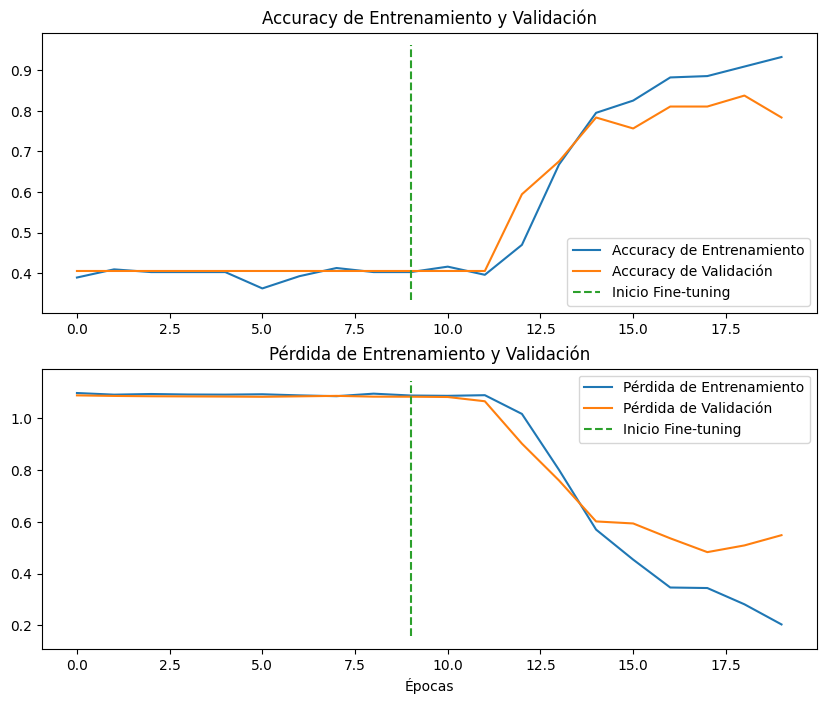

In [16]:
# --- 10. Visualizar el Historial de Entrenamiento ---
def plot_history(history_initial, history_fine_tune):
    acc = history_initial.history["accuracy"] + history_fine_tune.history["accuracy"]
    val_acc = (
        history_initial.history["val_accuracy"]
        + history_fine_tune.history["val_accuracy"]
    )
    loss = history_initial.history["loss"] + history_fine_tune.history["loss"]
    val_loss = (
        history_initial.history["val_loss"] + history_fine_tune.history["val_loss"]
    )

    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label="Accuracy de Entrenamiento")
    plt.plot(val_acc, label="Accuracy de Validación")
    plt.plot(
        [epochs_initial - 1, epochs_initial - 1],
        plt.ylim(),
        label="Inicio Fine-tuning",
        linestyle="--",
    )
    plt.legend(loc="lower right")
    plt.title("Accuracy de Entrenamiento y Validación")

    plt.subplot(2, 1, 2)
    plt.plot(loss, label="Pérdida de Entrenamiento")
    plt.plot(val_loss, label="Pérdida de Validación")
    plt.plot(
        [epochs_initial - 1, epochs_initial - 1],
        plt.ylim(),
        label="Inicio Fine-tuning",
        linestyle="--",
    )
    plt.legend(loc="upper right")
    plt.title("Pérdida de Entrenamiento y Validación")
    plt.xlabel("Épocas")
    plt.show()


plot_history(history_initial, history_fine_tune)
